# Deep Transfer Learning with Xfer

## Transfer learning in 3 lines of code:

            repurposer = xfer.LrRepurposer(source_model, feature_layer_names=['fc7'])
            repurposer.repurpose(train_iterator)
            predictions = repurposer.predict_label(test_iterator)

_Keep reading below to see Xfer in action!_


## Overview  

### What is Xfer?  
 
Xfer is a library that allows quick and easy transfer of knowledge stored in deep neural networks. It can be used for the classification of data of arbitrary numeric format, and can be applied to the common cases of image or text data. 

Xfer can be used as a pipeline that spans from extracting features to training a repurposer. The repurposer is then an object that performs classification in the target task.

You can also use individual components of Xfer as part of your own pipeline. For example, you can leverage the feature extractor to extract features from deep neural networks or ModelHandler, which allows for quick building of neural networks, even if you are not an MXNet expert.

### How can Xfer help me?  
- _Resource efficiency_: you don't have to train big neural networks from scratch.
- _Data efficiency_: by transferring knowledge, you can classify complex data even if you have very few labels. 
- _Easy access to neural networks_: you don't need to be an ML ninja in order to leverage the power of neural networks. With Xfer you can easily re-use them or even modify existing architectures and create your own solution. 
- _Uncertainty modeling_: With the Bayesian neural network (BNN) or the Gaussian process (GP) repurposers, you can obtain uncertainty in the predictions of the repurposer.
- _Utilities for feature extraction from neural networks_.
- _Rapid prototyping_.

### This Demo

In this notebook we demonstrate Xfer in an image classification task. A pre-trained neural network is selected, from which we transfer knowledge for the classification task in the *target* domain. The *target* task is a much smaller set of images that come from a different domain (hand-drawn sketches), therefore the classifier from the *source* task cannot be used as is, without repurposing. Therefore, the aim is to train a new classifier and it is vital to transfer knowledge from the *source* task, due to the extremely scarce *target* dataset. The new classifier for the *target* task is either a meta-model or a modified and fine-tuned clone of the *source* task's neural network.

### Components 

Xfer is comprised of 2 components:

* `ModelHandler` - Extracts features from pretrained model and performs model manipulation
* `Repurposer` - Repurposes model for target task

### Transfer Learing Pipeline  

In the following, we demonstrate the Xfer workflow:

1. A data iterator creation
2. A pre-trained model selection (i.e. picking a _source task_)
3. Feature extraction with the `ModelHandler`
4. `Repurposer` used to perform transfer learning from the source task to the target task

First we import or define all relevant modules and utilities.

In [1]:
import numpy as np
import os
import json
import random
import logging
import glob

import mxnet as mx
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from matplotlib import pylab as plt
%matplotlib inline

import xfer

seed=2
random.seed(seed)
np.random.seed(seed)
mx.random.seed(seed)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Change the default option below to test Xfer on other datasets (or use your own!).
TEST_IMAGES = 'test_sketches/' # Options: 'test_images' or 'test_sketches' or 'test_images_sketch'

In [2]:
def get_iterators_from_folder(data_dir, train_size=0.6, batchsize=10, label_name='softmax_label', data_name='data', random_state=1):
    """
    Method to create iterators from data stored in a folder with the following structure:
    /data_dir
        /class1
            class1_img1
            class1_img2
            ...
            class1_imgN
        /class2
            class2_img1
            class2_img2
            ...
            class2_imgN
        ...
        /classN
    """
    # assert dir exists
    if not os.path.isdir(data_dir):
        raise ValueError('Directory not found: {}'.format(data_dir))
    # get class names
    classes = [x.split('/')[-1] for x in glob.glob(data_dir+'/*')]
    classes.sort()
    fnames = []
    labels = []
    for c in classes:
            # get all the image filenames and labels
            images = glob.glob(data_dir+'/'+c+'/*')
            images.sort()
            fnames += images
            labels += [c]*len(images)
    # create label2id mapping
    id2label = dict(enumerate(set(labels)))
    label2id = dict((v,k) for k, v in id2label.items())

    # get indices of train and test
    sss = StratifiedShuffleSplit(n_splits=2, test_size=None, train_size=train_size, random_state=random_state)
    train_indices, test_indices = next(sss.split(labels, labels))
    
    train_img_list = []
    test_img_list = []
    train_labels = []
    test_labels = []
    # create imglist for training and test
    for idx in train_indices:
        train_img_list.append([label2id[labels[idx]], fnames[idx]])
        train_labels.append(label2id[labels[idx]])
    for idx in test_indices:
        test_img_list.append([label2id[labels[idx]], fnames[idx]])
        test_labels.append(label2id[labels[idx]])
        
    # make iterators
    train_iterator = mx.image.ImageIter(batchsize, (3,224,224), imglist=train_img_list, label_name=label_name, data_name=data_name,
                                        path_root='')
    test_iterator = mx.image.ImageIter(batchsize, (3,224,224), imglist=test_img_list, label_name=label_name, data_name=data_name,
                                      path_root='')

    return train_iterator, test_iterator, train_labels, test_labels, id2label, label2id


def get_images(iterator):
    """
    Returns list of image arrays from iterator
    """
    iterator.reset()
    images = []
    while True:
        try:
            batch = iterator.next().data[0]
            for n in range(batch.shape[0]):
                images.append(batch[n])
        except StopIteration:
            break
    return images


def show_predictions(predictions, images, id2label, uncertainty=None, figsize=(9,1.2), fontsize=12, n=8):
    """
    Plots images with predictions as labels. If uncertainty is given then this is plotted below as a
    series of horizontalbar charts.
    """
    num_rows = 1 if uncertainty is None else 2
    
    plt.figure(figsize=figsize)
    for cc in range(n):
        plt.subplot(num_rows,n,1+cc)
        plt.tick_params(
                        axis='both',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        left=False,
                        labelleft=False,
                        labelbottom=False) # labels along the bottom edge are off
        plt.imshow(np.uint8(images[cc].asnumpy().transpose((1,2,0))))
        plt.title(id2label[predictions[cc]].split(',')[0], fontsize=fontsize)
        plt.axis

    if uncertainty is not None:
        pos = range(len(id2label.values()))
        for cc in range(n):
            plt.subplot(num_rows,n,n+1+cc)
            # Normalize the bars to be 0-1 for better readability.
            xx = uncertainty[cc]
            xx = (xx-min(xx))/(max(xx)-min(xx))
            plt.barh(pos, xx, align='center', height=0.3)
            if cc == 0:
                plt.yticks(pos, id2label.values())
            else:
                plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            plt.grid(True)

## Data Handling

In order for Xfer to process data, it must be given as an MXNet data iterator (`mxnet.io.DataIter`). MXNet expects labels to be sequential integers starting at zero so we have mapped all our string labels to integers to avoid any unexpected behaviours.

The data handling portion of the workflow is made up of the following steps:

* Get iterators
* Get labels
* Get label to idx mapping dictionary

In [3]:
# We have chosen to split the data into train and test at a 60:40 ratio and use a batchsize of 4
train_iterator, test_iterator, train_labels, test_labels, id2label, label2id = get_iterators_from_folder(TEST_IMAGES, 0.6, 4, label_name='prob_label', random_state=1)

INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading image list...
INFO:root:Using 1 threads for decoding...
INFO:root:Set enviroment variable MXNET_CPU_WORKER_NTHREADS to a larger number to use more threads.
INFO:root:ImageIter: loading image list...


## Source Model
ModelHandler is an Xfer module which handles everything related to the source pre-trained neural network. It can extract features given a target dataset and source model, and it can also manipulate the pre-trained network by adding/removing/freezing layers (we'll see this functionality in the next section). For now, we simply:

* Load MXNet Module from file
* Instantiate `ModelHandler` object with VGG-19 model as source model

The VGG-19 model is a convolutional neural network trained on ImageNet and is good at image classification. Other models trained on ImageNet are likely to be good source models for this task.

In [4]:
# Download model
path = 'http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'vgg/vgg19-0000.params'),
mx.test_utils.download(path+'vgg/vgg19-symbol.json')]

INFO:root:vgg19-0000.params exists, skipping download
INFO:root:vgg19-symbol.json exists, skipping download


['vgg19-0000.params', 'vgg19-symbol.json']

In [5]:
source_model = mx.module.Module.load('vgg19', 0, label_names=['prob_label'])
mh = xfer.model_handler.ModelHandler(source_model)

## How well the pre-trained network alone is doing (without repurposing)?

This section will show how well the pre-trained *source* model performs before any repurposing is applied.

In [6]:
# Get pre-trained model without modifications
model = mh.get_module(iterator=test_iterator)
# Predict on our test data
predictions = np.argmax(model.predict(test_iterator), axis=1).asnumpy().astype(int)

In [7]:
# This utility just allows us to translate image-id's of the imagenet dataset to human-readable labels
with open('imagenet1000-class-to-human.json', 'r') as fp:
    imagenet_class_to_human = json.load(fp)
    
imagenet_class_to_human = {int(k): v for k, v in imagenet_class_to_human.items()}

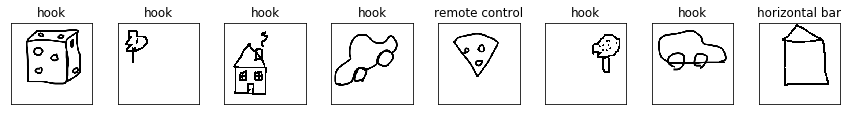

In [8]:
# Plot all test images along with the predicted labels
images = get_images(test_iterator)

show_predictions(predictions, images, imagenet_class_to_human, None, (15, 1.5))

The model is performing badly on our sketch images - it thinks most of our drawings are hooks! The reason for this is that the label and image distribution in the target task are different (having come from a different dataset) i.e the model has been trained on photographs of objects and so cannot sensibly classify these sketches. The results would get worse if the source/target dataset mismatch was larger. A __repurposing__ step is required to better align the pre-trained model with the target data. 

## Repurposing

### (a) Repurposing with meta-models

By repurposing with meta models, we use the neural network as a feature extractor and fit a different model on these features. 

In [9]:
# Instantiate a Logistic Regression repurposer (other options: SVM; GP; NN, BNN repurposers)
logging.info("Logistic Regression (LR) Repuroser")
repLR = xfer.LrRepurposer(source_model=source_model, feature_layer_names=['fc7'])
repLR.repurpose(train_iterator)
predictionsLR = repLR.predict_label(test_iterator)

logging.info("LR Repurposer - Classification Results")
print(classification_report(test_labels, predictionsLR, target_names=list(id2label.values()), digits=3))

INFO:root:Logistic Regression (LR) Repuroser
INFO:root:Extracting features from layers: fc7
INFO:root:Processed batch 1
INFO:root:Processed batch 2
INFO:root:Processed batch 3
INFO:root:Processed batch 4
INFO:root:Processed batch 5
INFO:root:Processed batch 6
 /anaconda/envs/matplotlib-backend/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:The max_iter was reached which means the coef_ did not converge
INFO:root:Extracting features from layers: fc7
INFO:root:Processed batch 1
INFO:root:Processed batch 2
INFO:root:Processed batch 3
INFO:root:Processed batch 4
INFO:root:LR Repurposer - Classification Results


             precision    recall  f1-score   support

       tree      1.000     0.750     0.857         4
        car      1.000     1.000     1.000         4
     cheese      1.000     1.000     1.000         4
      house      0.800     1.000     0.889         4

avg / total      0.950     0.938     0.937        16



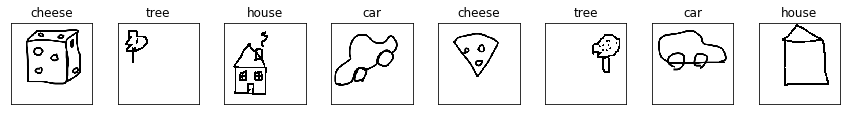

In [10]:
show_predictions(predictionsLR, images, id2label, None, (15,1.5))

### (b) Fine-tuning Neural Network repurposer

Neural network repurposers will:

* Modify the pretrained neural network architecture by adding and removing layers
* Retrain the network with certain layers held fixed or randomised

In [11]:
# Choose which layers of the model to fix during training - more fixed layers lead to faster training
fixed_layers = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2','conv3_3','conv3_4',
                'conv4_1','conv4_2', 'conv4_3','conv4_4','conv5_1','conv5_2','conv5_3', 'conv5_4']
# Choose which layers of the model to randomise before training - we may want to forget some of what
# this model knows
random_layers = []

repNN = xfer.NeuralNetworkRandomFreezeRepurposer(source_model, target_class_count=4, fixed_layers=fixed_layers, random_layers=random_layers)
repNN.repurpose(train_iterator)
predictionsNN = repNN.predict_label(test_iterator)
logging.info("NN Repurposer - Classification Results")
print(classification_report(test_labels, predictionsNN, target_names=list(id2label.values()), digits=3))

INFO:root:fc8, prob deleted from model top
INFO:root:Added new_fully_connected_layer, prob to model top
 /anaconda/envs/matplotlib-backend/lib/python3.5/site-packages/mxnet/module/base_module.py:488: UserWarning:Parameters already initialized and force_init=False. init_params call ignored.
INFO:root:Epoch[0] Train-accuracy=0.541667
INFO:root:Epoch[0] Time cost=33.846
INFO:root:Epoch[1] Train-accuracy=1.000000
INFO:root:Epoch[1] Time cost=22.451
INFO:root:Epoch[2] Train-accuracy=1.000000
INFO:root:Epoch[2] Time cost=24.884
INFO:root:Epoch[3] Train-accuracy=1.000000
INFO:root:Epoch[3] Time cost=23.454
INFO:root:Epoch[4] Train-accuracy=1.000000
INFO:root:Epoch[4] Time cost=24.850
INFO:root:NN Repurposer - Classification Results


             precision    recall  f1-score   support

       tree      1.000     0.750     0.857         4
        car      1.000     1.000     1.000         4
     cheese      1.000     1.000     1.000         4
      house      0.800     1.000     0.889         4

avg / total      0.950     0.938     0.937        16



The neural network repurposer will likely not be great if the target dataset is extremely small.

### (c) Repurposing with probability and uncertainty  
Two repurposers offer well-calibrated probability for predictions: `GPRepurposer` and `BNNRepurposer`. Here we explore the former (the latter can be used for non-tiny datasets).

In [12]:
# Instantiate a GP repurposer
repGP = xfer.GpRepurposer(source_model, feature_layer_names=['fc6'], apply_l2_norm=True)
repGP.repurpose(train_iterator)

logging.info("GP Repurposer - Classification Results")
uncertaintyGP = repGP.predict_probability(test_iterator)
predictionsGP = np.argmax(uncertaintyGP, axis=1)

print(classification_report(test_labels, predictionsGP,
    target_names=list(id2label.values()), digits=3))

INFO:root:Extracting features from layers: fc6
INFO:root:Processed batch 1
INFO:root:Processed batch 2
INFO:root:Processed batch 3
INFO:root:Processed batch 4
INFO:root:Processed batch 5
INFO:root:Processed batch 6
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:root:GP Repurposer - Classification Results
INFO:root:Extracting features from layers: fc6
INFO:root:Processed batch 1
INFO:root:Processed batch 2
INFO:root:Processed batch 3
INFO:root:Processed batch 4


             precision    recall  f1-score   support

       tree      1.000     0.750     0.857         4
        car      1.000     1.000     1.000         4
     cheese      1.000     1.000     1.000         4
      house      0.800     1.000     0.889         4

avg / total      0.950     0.938     0.937        16



The code below will plot the predictions and the probability for each class.

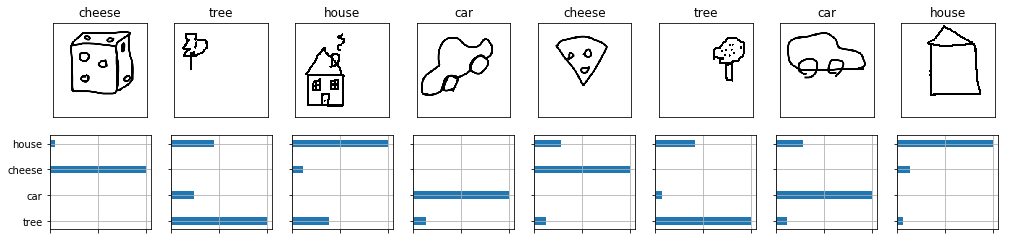

In [13]:
show_predictions(predictionsGP, images, id2label, uncertaintyGP, (17,3.8))

We not only have predictions from this model but we can also see the uncertainty in the model for any given predition which allows us to make better decisions on our data.

### Other repurposers
We have seen the use of LrRepurposer, NeuralNetworkRandomFreezeRepurposer and GpRepurposer.  Other repurposers offered are: SvmRepurposer, BnnRepurposer, NeuralNetworkFineTuneRepurposer.

You can also [write your own repurposer](xfer-custom-repurposers.rst)

## Using Xfer on your own data  
All you need to do is generate your own data iterator and use it instead of the iterators used above.

For more details see the [API documentation](../api.html)